In [1]:
import jax
import jax.numpy as jnp
from jax import random
from jax import jit, vmap, grad, hessian
from jax import scipy as jsc
import matplotlib.pylab as plt
import seaborn as sns
from scipy.stats import chi2
import numpy as np

sns.set(style="whitegrid")

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tqdm import tqdm
import seaborn as sns

from jax.scipy.special import expit

In [2]:
@jit
def predict(params, x):
    mu = params[0] + params[1] * x
    p = expit(mu) # transformation (inverse logit function = expit)
    return p

def generate_data(key, sample_size = 30, params = [0.7, 0.4]):
    key1, key2 = random.split(key, 2)
    X = 10.0 * random.normal(key1, shape=(sample_size,)) + 10.0
    mu = params[0] + params[1] * X
    p = expit(mu) # transformation (inverse logit function = expit)

    # Generate data
    y = random.bernoulli(key2, p)
    y = np.where(y, 1, 0)
    return X, y, p

@jit
def loss_function(params, X, y):
    diff = (y - predict(params, X))**2
    return jnp.mean(diff)

def top_k_indices(array, k):
    if k == 1:
        indices = jnp.argmax(array)
    elif k > 1:
        indices = jnp.argsort(array)[::-1][:k]
    else:
        raise ValueError("k should be an integer above 0.")
    return indices


vectorized_predict = vmap(predict, in_axes=(None, 0))

# Compute the first-order derivative using vmap and grad
grad_predict = vmap(grad(predict), in_axes=(None, 0), out_axes=0)

loss_grad = jit(grad(loss_function))
loss_grad_vmap = vmap(loss_grad, in_axes=(None, 0, 0))

vectorized_loss_function = jit(vmap(loss_function, in_axes=(None, 0, 0)))
hessian_loss = jit(hessian(vectorized_loss_function))

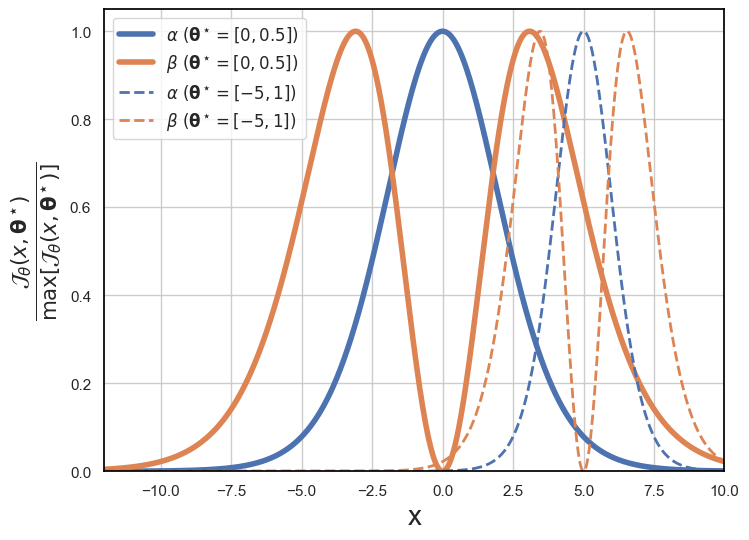

In [3]:
# Vectorize the predict() function based on X
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
X = jnp.linspace(-15, 10.0, 2001)  # Example input
params = jnp.array([0.0, 0.5])  # Example params
first_order_derivative = grad_predict(params, X)**2 / jnp.max(grad_predict(params, X)**2, axis=0)
plt.plot(X, first_order_derivative, lw=4)

params = jnp.array([-5, 1.0])  # Example params
first_order_derivative = grad_predict(params, X).T

first_order_derivative_1 = first_order_derivative[1] + (params[0] / params[1])*first_order_derivative[0]
first_order_derivative = jnp.array([first_order_derivative[0], first_order_derivative_1]).T
first_order_derivative = first_order_derivative**2 / jnp.max(first_order_derivative**2, axis=0)

plt.gca().set_prop_cycle(None)
plt.plot(X, first_order_derivative, '--', lw=2)

plt.ylabel(r'$\frac{\mathcal{J}_{\theta}(x, {\bf \theta^\star})}{\max[\mathcal{J}_{\theta}(x, {\bf \theta^\star})]}$', size=22)

plt.legend([r'$\alpha\ ({\bf \theta^\star}=[0, 0.5])$',
              r'$\beta\ ({\bf \theta^\star}=[0, 0.5])$',
              r'$\alpha\ ({\bf \theta^\star}=[-5, 1])$',
              r'$\beta\ ({\bf \theta^\star}=[-5, 1])$'], loc='upper left', prop={'size':12})
plt.xlabel('x', size=20)
plt.xlim(-12, 10)
plt.ylim(0, 1.05)

plt.grid(True)
ax.spines["top"].set_color("black")
ax.spines["right"].set_color("black")
ax.spines["bottom"].set_color("black")
ax.spines["left"].set_color("black")

plt.savefig('../plots/logit_fisher_info.pdf', format="pdf", bbox_inches="tight")

NameError: name 'data' is not defined

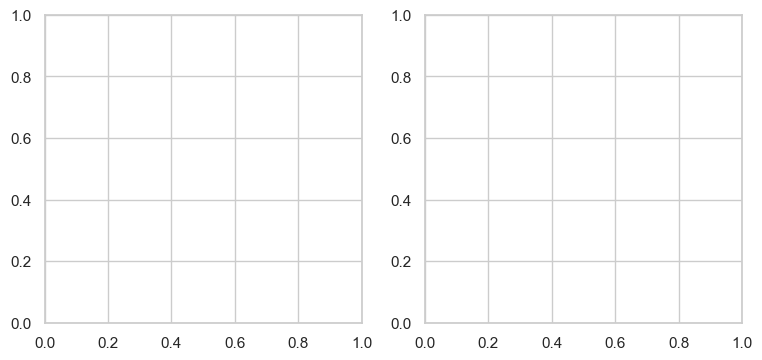